In [1]:
# # download images and annotations to the data directory
# !wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip -P ./data_dir/ -P ./data_dir/
# !wget http://images.cocodataset.org/zips/train2014.zip -P ./data_dir/
# !wget http://images.cocodataset.org/zips/val2014.zip -P ./data_dir/
# # extract zipped images and annotations and remove the zip files
# !unzip ./data_dir/annotations_trainval2014.zip -d ./data_dir/
# !rm ./data_dir/annotations_trainval2014.zip
# !unzip ./data_dir/train2014.zip -d ./data_dir/
# !rm ./data_dir/train2014.zip
# !unzip ./data_dir/val2014.zip -d ./data_dir/
# !rm ./data_dir/val2014.zip

In [ ]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("adityajn105/flickr8k")

# print("Path to dataset files:", path)

100%|██████████| 1.04G/1.04G [02:19<00:00, 7.96MB/s]

Extracting files...


Path to dataset files: /home/silly_ronny/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1


# Preprocessing caption data

In [181]:
import pandas as pd
data_path = "/home/silly_ronny/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1"
images_path = f"{data_path}/Images"
caption_file = f"{data_path}/captions.txt"

In [182]:
captions = pd.read_csv(caption_file, sep=",")
captions.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [183]:
captions.shape

(40455, 2)

In [184]:
import nltk
from pycocotools.coco import COCO
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as transforms
from torch.nn.utils.rnn import pack_padded_sequence

In [185]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     /home/silly_ronny/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [187]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(captions, test_size=0.2, random_state=42)
train_df.shape, val_df.shape

((32364, 2), (8091, 2))

In [194]:
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import unicodedata
import string

class ImageCaptioningDataset(Dataset):
    def __init__(self, data, images_path, transforms, tokenizer):
        self.captions = data['caption'].tolist()
        self.images = data['image'].tolist()
        self.images_path = images_path
        self.transforms = transforms
        self.tokenizer = tokenizer
    
    def process_sentence(self, tokens):
        """
        Normalize tokens by:
        - Converting to lowercase
        - Removing punctuation
        - Stripping whitespace
        - Normalizing Unicode characters to their ASCII equivalents
        """
        normalized_tokens = []
        for token in tokens:
            # Normalize Unicode characters to ASCII
            token = unicodedata.normalize('NFKD', token).encode('ascii', 'ignore').decode('utf-8')
            # Convert to lowercase
            token = token.lower()
            # Remove punctuation and strip whitespace
            token = token.strip(string.punctuation).strip()
            # Add to the result list if not empty
            if token:
                normalized_tokens.append(token)
        
        normalized_tokens = ['<sos>'] + normalized_tokens + ["<eos>"]
        return normalized_tokens
    
    def __getitem__(self, idx):
        caption = self.captions[idx]
        caption = self.process_sentence(self.tokenizer(caption))
        image_name = self.images[idx]
        image_path = os.path.join(self.images_path, image_name)

        return caption, self.transforms(Image.open(image_path))
    
    def __len__(self):
        return len(self.captions)

In [195]:
import nltk
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
weights = EfficientNet_V2_S_Weights.DEFAULT



train_transforms = weights.transforms()
val_transforms = weights.transforms()

tokenizer = nltk.word_tokenize

train_dataset = ImageCaptioningDataset(train_df, images_path,
                                   transforms=train_transforms, tokenizer=tokenizer)
val_dataset = ImageCaptioningDataset(val_df, images_path,
                                   transforms=val_transforms, tokenizer=tokenizer)

len(train_dataset), len(val_dataset)

(32364, 8091)

In [197]:
from tqdm import tqdm
for cap, img in tqdm(val_dataset):
    pass

100%|██████████| 8091/8091 [00:41<00:00, 196.72it/s]


In [199]:
from typing import List
import string
import unicodedata
from tqdm import tqdm

class Vocab:
    def __init__(self):
        self.word2idx = {"<pad>": 0, "<unk>": 1, "<sos>": 2, "<eos>": 3}
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}
        self.n = 4
    
    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.n
            self.idx2word[self.n] = word
            self.n = self.n+1
    
    def build_with_sentence(self, sentence):
        for word in (sentence):
            self.add_word(word)
            
    
    def build_vocab(self, list_of_sentences: List[str]):
        for sentence in tqdm(list_of_sentences):
            self.build_with_sentence(sentence=sentence)
  
    def __getitem__(self, word):
        return self.word2idx.get(word, 1)
    
    def get_word(self, idx):
        return self.idx2word.get(idx, "<unk>")

In [201]:
vocab = Vocab()
for caption, _ in tqdm(train_dataset):
    vocab.build_with_sentence(caption)
for caption, _ in tqdm(val_dataset):
    vocab.build_with_sentence(caption)

100%|██████████| 8091/8091 [00:37<00:00, 214.35it/s]


In [203]:
import joblib
joblib.dump(vocab, "vocab.z")
vocab = joblib.load("vocab.z")

In [204]:
vocab.word2idx

{'<pad>': 0,
 '<unk>': 1,
 '<sos>': 2,
 '<eos>': 3,
 'a': 4,
 'man': 5,
 'and': 6,
 'dog': 7,
 'are': 8,
 'standing': 9,
 'on': 10,
 'tree': 11,
 'that': 12,
 'has': 13,
 'fallen': 14,
 'over': 15,
 'to': 16,
 'the': 17,
 'ground': 18,
 'three': 19,
 'boys': 20,
 'who': 21,
 'wearing': 22,
 'life': 23,
 'jackets': 24,
 'looking': 25,
 'into': 26,
 'water': 27,
 'woman': 28,
 'with': 29,
 'camera': 30,
 'very': 31,
 'long': 32,
 'lens': 33,
 'takes': 34,
 'picture': 35,
 'red': 36,
 'crash': 37,
 'helmet': 38,
 'native': 39,
 'american': 40,
 'tattoo': 41,
 'her': 42,
 'arm': 43,
 'one': 44,
 'person': 45,
 'is': 46,
 'whispering': 47,
 'another': 48,
 'two': 49,
 'large': 50,
 'dogs': 51,
 'fighting': 52,
 'teeth': 53,
 'bared': 54,
 'near': 55,
 'some': 56,
 'trees': 57,
 'swims': 58,
 'in': 59,
 'lake': 60,
 'wet': 61,
 'walks': 62,
 'out': 63,
 'of': 64,
 'an': 65,
 'orange': 66,
 'dress': 67,
 'riding': 68,
 'carnival': 69,
 'ride': 70,
 'black': 71,
 'carries': 72,
 'huge': 73,
 '

In [207]:
import torch 

from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence
def collate_fn(batch):
    # max_len = 21
    captions, images = zip(*batch)
    tokens = [torch.tensor([vocab[token] for token in caption])
              for caption in captions]
    lengths = torch.tensor([len(tok) for tok in tokens])
    captions = pad_sequence(tokens, batch_first=True, padding_value=0)
    lengths, idxs = lengths.sort(descending=True)
    captions = captions[idxs]
    images = torch.stack(images)
    images = images[idxs]
    return images, captions, lengths
    
torch.manual_seed(42)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

In [208]:
for images, captions, lens in train_dataloader:
    print(images.shape, captions, lens)
    break

torch.Size([8, 3, 384, 384]) tensor([[   2,    4,   45,   59,  110,  483,  211,    4,   31,  185,  590,  702,
          446,   36,    6,  110, 1412,    3],
        [   2,   49,  320,   59,   78,  148,  154,   17,  468,   10,    4,  757,
            3,    0,    0,    0,    0,    0],
        [   2,   17,  220,   84,   59,   71,    6,   66,   62,  113,   17,  155,
            3,    0,    0,    0,    0,    0],
        [   2,   17,  321,  526,  260,   46,  669,   16, 3297,  861, 1997,    3,
            0,    0,    0,    0,    0,    0],
        [   2,    4,  206,   59,    4,  110,  131,   46,   59,    4,  323,    3,
            0,    0,    0,    0,    0,    0],
        [   2,   49,   51,  108,   59,   17,  107,   29,   65,  560,  100,    3,
            0,    0,    0,    0,    0,    0],
        [   2,    4, 7185,    5, 2656, 7186,   10,   17,  197,    3,    0,    0,
            0,    0,    0,    0,    0,    0],
        [   2,    4, 1120,   64,   65, 1281,    5,    3,    0,    0,    0,    0,
 

In [209]:
for images, captions, lens in tqdm(val_dataloader):
    # print(images.shape, captions.shape, lens)
    pass
    # break

100%|██████████| 1012/1012 [00:40<00:00, 25.21it/s]


In [210]:
import torch
import torch.nn as nn

class VisionEncoder(nn.Module):
    def __init__(self, embedding_size):
        super().__init__()
        self.model = efficientnet_v2_s(weights=weights)
        self.model.classifier = nn.Sequential(nn.Linear(1280, embedding_size))
        self.batch_norm = nn.BatchNorm1d(embedding_size, momentum=0.01)
    
    def forward(self, input_images):
        with torch.no_grad():
            features = self.model(input_images)
            features = self.batch_norm(features)
        
        return features

In [211]:
VisionEncoder(768)(torch.randn(8, 3, 384, 384)).shape

torch.Size([8, 768])

In [212]:
from torch.nn.utils.rnn import pad_packed_sequence
class TextDecoder(nn.Module):
    def __init__(self, embedding_size, hidden_size, vocabulary_size, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True)
        self.linear_layer = nn.Linear(hidden_size, vocabulary_size)
    
    def forward(self, input_features, capts, lens):
        embeddings = self.embedding(capts)
        features = torch.cat([input_features.unsqueeze(1), embeddings], dim=1)
        features = pack_padded_sequence(features, lens, batch_first=True)
        out, _ = self.rnn(features)
        out, _ = pad_packed_sequence(out, batch_first=True)
        out = self.linear_layer(out)
        return out

In [213]:
torch.manual_seed(3)
torch.cuda.manual_seed(3)
for image, captions, lens in train_dataloader:
    print(captions.shape)
    print(TextDecoder(768, 512, len(vocab.word2idx), 1)(torch.randn((8, 768)), captions, lens).shape)
    break

torch.Size([8, 19])
torch.Size([8, 19, 8903])


# Training

In [214]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [233]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
encoder_model = VisionEncoder(256).to(device)
decoder_model = TextDecoder(256, 512, len(vocab.word2idx), 1).to(device)

criterion = nn.CrossEntropyLoss()
parameters = list(decoder_model.parameters()) + \
    list(encoder_model.model.classifier.parameters()) + \
    list(encoder_model.batch_norm.parameters())

optimizer = torch.optim.Adam(parameters, lr=0.001)

In [234]:
from tqdm import tqdm
import numpy as np

def train(encoder_model, decoder_model, train_dataloader, criterion, optimizer):
    total_loss = 0.0
    total_num_steps = len(train_dataloader)
    encoder_model.train()
    decoder_model.train()
    # Initialize tqdm progress bar
    progress_bar = tqdm(enumerate(train_dataloader), total=total_num_steps, desc="Training", leave=True)

    for i, (imgs, capts, lens) in progress_bar:
        # try:
            imgs = imgs.to(device)
            capts = capts.to(device)

            optimizer.zero_grad()

            feats = encoder_model(imgs)
            output = decoder_model(feats, capts, lens)
            output = output.view(-1, 8903)
            capts = capts.view(-1)
            loss = criterion(output, capts)
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

            # Update tqdm progress bar with average loss
            avg_loss = total_loss / (i + 1)
            progress_bar.set_postfix({"Avg Loss": f"{avg_loss:.4f}", "Perplexity": f"{np.exp(avg_loss):.4f}"})

        # except Exception as e:
        #     # Log the error and continue
        #     print(f"Error in batch {i}: {e}")
        #     continue

    # Return the average loss after training
    avg_loss = total_loss / total_num_steps
    return avg_loss

In [235]:
def val(encoder_model, decoder_model, val_dataloader, criterion):
    total_loss = 0.0
    total_num_steps = len(val_dataloader)

    encoder_model.eval()
    decoder_model.eval()
    # Initialize tqdm progress bar
    progress_bar = tqdm(enumerate(val_dataloader), total=total_num_steps, desc="Validation", leave=True)
    with torch.inference_mode():
        for i, (imgs, capts, lens) in progress_bar:
            try:
                imgs = imgs.to(device)
                capts = capts.to(device)

                feats = encoder_model(imgs)
                output = decoder_model(feats, capts, lens).view(-1, 8903)
                capts = capts.view(-1)

                loss = criterion(output, capts)
                total_loss += loss.item()

                # Update tqdm progress bar with average loss
                avg_loss = total_loss / (i + 1)
                progress_bar.set_postfix({"Avg Loss": f"{avg_loss:.4f}", "Perplexity": f"{np.exp(avg_loss):.4f}"})

            except Exception as e:
                # Log the error and continue
                print(f"Error in batch {i}: {e}")
                continue

    # Return the average loss after training
    avg_loss = total_loss / total_num_steps
    return avg_loss

In [236]:
import torch

def train_validate(encoder_model, decoder_model, train_dataloader, val_dataloader, criterion, optimizer, epochs=3):
    # Initialize history dictionary
    history = {'train_loss': [], 'val_loss': []}

    # Variable to track the best validation loss
    best_val_loss = float('inf')

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")

        # Training Phase
        train_loss = train(encoder_model, decoder_model, train_dataloader, criterion, optimizer)
        history['train_loss'].append(train_loss)
        print(f"Training Loss: {train_loss:.4f}")

        # Validation Phase
        val_loss = val(encoder_model, decoder_model, val_dataloader, criterion)
        history['val_loss'].append(val_loss)
        print(f"Validation Loss: {val_loss:.4f}")


        # Update and save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(encoder_model.state_dict(), "models_dir/best_encoder_model.pth")
            torch.save(decoder_model.state_dict(), "models_dir/best_decoder_model.pth")
            print("Best model updated and saved.")

    print("Training complete. Best models saved as 'best_encoder_model.pth' and 'best_decoder_model.pth'.")
    return history


In [237]:
history = train_validate(encoder_model, decoder_model, train_dataloader, val_dataloader, criterion, optimizer, epochs=10)


Epoch 1/10


Training: 100%|██████████| 4046/4046 [05:07<00:00, 13.17it/s, Avg Loss=4.2389, Perplexity=69.3286] 


Training Loss: 4.2389


Validation: 100%|██████████| 1012/1012 [01:09<00:00, 14.48it/s, Avg Loss=3.2405, Perplexity=25.5456]


Validation Loss: 3.2405
Best model updated and saved.

Epoch 2/10


Training: 100%|██████████| 4046/4046 [05:05<00:00, 13.25it/s, Avg Loss=2.4419, Perplexity=11.4950]


Training Loss: 2.4419


Validation: 100%|██████████| 1012/1012 [01:10<00:00, 14.42it/s, Avg Loss=2.1493, Perplexity=8.5788]


Validation Loss: 2.1493
Best model updated and saved.

Epoch 3/10


Training: 100%|██████████| 4046/4046 [05:13<00:00, 12.89it/s, Avg Loss=1.6766, Perplexity=5.3471]


Training Loss: 1.6766


Validation: 100%|██████████| 1012/1012 [01:14<00:00, 13.67it/s, Avg Loss=1.9801, Perplexity=7.2434]


Validation Loss: 1.9801
Best model updated and saved.

Epoch 4/10


Training: 100%|██████████| 4046/4046 [05:35<00:00, 12.05it/s, Avg Loss=1.4306, Perplexity=4.1811]


Training Loss: 1.4306


Validation: 100%|██████████| 1012/1012 [01:15<00:00, 13.45it/s, Avg Loss=1.9923, Perplexity=7.3326]


Validation Loss: 1.9923

Epoch 5/10


Training: 100%|██████████| 4046/4046 [05:32<00:00, 12.16it/s, Avg Loss=1.2770, Perplexity=3.5858]


Training Loss: 1.2770


Validation: 100%|██████████| 1012/1012 [01:15<00:00, 13.43it/s, Avg Loss=2.0409, Perplexity=7.6975]


Validation Loss: 2.0409

Epoch 6/10


Training: 100%|██████████| 4046/4046 [05:35<00:00, 12.07it/s, Avg Loss=1.1646, Perplexity=3.2045]


Training Loss: 1.1646


Validation: 100%|██████████| 1012/1012 [01:16<00:00, 13.28it/s, Avg Loss=2.0886, Perplexity=8.0740]


Validation Loss: 2.0886

Epoch 7/10


Training: 100%|██████████| 4046/4046 [05:29<00:00, 12.28it/s, Avg Loss=1.0733, Perplexity=2.9250]


Training Loss: 1.0733


Validation: 100%|██████████| 1012/1012 [01:15<00:00, 13.36it/s, Avg Loss=2.1519, Perplexity=8.6010]


Validation Loss: 2.1519

Epoch 8/10


Training: 100%|██████████| 4046/4046 [05:26<00:00, 12.38it/s, Avg Loss=1.0023, Perplexity=2.7245]


Training Loss: 1.0023


Validation: 100%|██████████| 1012/1012 [01:15<00:00, 13.35it/s, Avg Loss=2.2084, Perplexity=9.1012]


Validation Loss: 2.2084

Epoch 9/10


Training: 100%|██████████| 4046/4046 [05:25<00:00, 12.43it/s, Avg Loss=0.9443, Perplexity=2.5710]


Training Loss: 0.9443


Validation: 100%|██████████| 1012/1012 [01:15<00:00, 13.49it/s, Avg Loss=2.2694, Perplexity=9.6732]


Validation Loss: 2.2694

Epoch 10/10


Training: 100%|██████████| 4046/4046 [05:31<00:00, 12.21it/s, Avg Loss=0.8983, Perplexity=2.4554]


Training Loss: 0.8983


Validation: 100%|██████████| 1012/1012 [01:13<00:00, 13.79it/s, Avg Loss=2.3247, Perplexity=10.2233]

Validation Loss: 2.3247
Training complete. Best models saved as 'best_encoder_model.pth' and 'best_decoder_model.pth'.


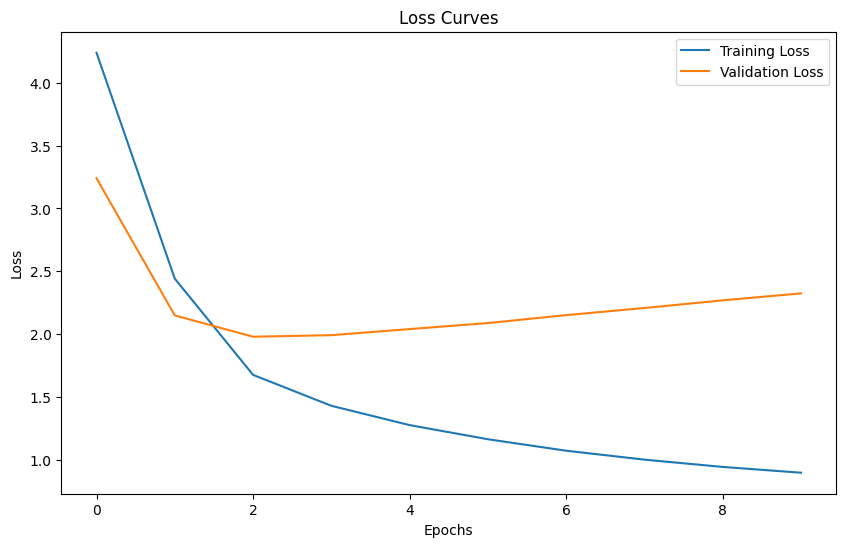

In [238]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()
    plt.show()

# Example usage
plot_loss_curves(history)

In [239]:
sample_img_path = "data_dir/train2014/COCO_train2014_000000581073.jpg"
from PIL import Image

img = Image.open(sample_img_path)
encoder_model.eval()
decoder_model.eval()
with torch.inference_mode():
    encoder_out = encoder_model(train_transforms(img).unsqueeze(0).to(device))
    start_token = torch.tensor([vocab["<sos>"]]).unsqueeze(0).to(device)
    hidden_states = None
    emb = decoder_model.embedding(start_token)
    lstm_input = torch.cat([encoder_out.unsqueeze(1), emb], dim=1)
    hidden, lstm_states = decoder_model.rnn(lstm_input, hidden_states)

    linear_out = decoder_model.linear_layer(hidden)

In [243]:
linear_out.argmax(dim=-1)

tensor([[2, 4]], device='cuda:0')

In [271]:
def generate_caption(model, encoder, img, vocab, device, max_len=20):
    model.eval()
    encoder.eval()
    
    transformed_img = train_transforms(img)
    with torch.inference_mode():
        encoder_out = encoder(transformed_img.unsqueeze(0).to(device)) 
    
    start_token = torch.tensor([vocab["<sos>"]]).unsqueeze(0).to(device)  
    generated_caption = [start_token]  
    
    hidden_states = None
    for _ in range(max_len):
        emb = model.embedding(start_token)  # Shape: [1, 1, embedding_size]
        lstm_input = torch.cat([encoder_out.unsqueeze(1), emb], dim=1)  # Concatenate [1, 1, embedding_size] with [1, 1, embedding_size] to get [1, 2, embedding_size]
        
        out, hidden_states = model.rnn(lstm_input, hidden_states)
        out = model.linear_layer(out)  # Shape: [1, 1, vocab_size]
        
        predicted_idx = out.argmax(dim=-1)[:, -1]  # Shape: [1] taking the last one at dim 1
        predicted_word = vocab.idx2word[predicted_idx.item()]
        
        generated_caption.append(predicted_word)
        
        start_token = predicted_idx.unsqueeze(0)  
        
        if predicted_word == "<eos>":
            break
    
    return " ".join(generated_caption[1:])  


'a tennis ball on a shot of a tennis <eos>'

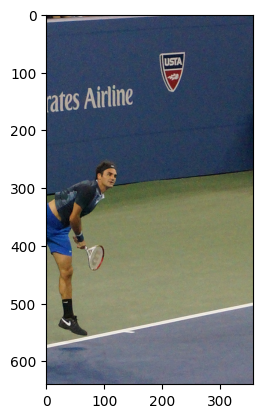

In [272]:
sample_img_path = "data_dir/val2014/COCO_val2014_000000000415.jpg"
img = Image.open(sample_img_path)
plt.imshow(img)

generate_caption(decoder_model, encoder_model,img, vocab, device=device)

'a man climbing <eos>'

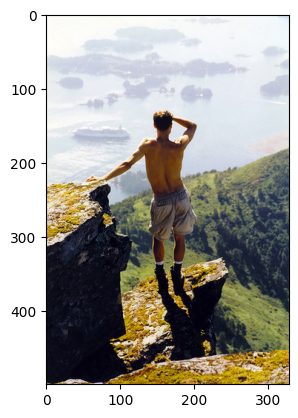

In [279]:
sample_img_path = os.path.join(images_path, val_df['image'].iloc[2])
img = Image.open(sample_img_path)
plt.imshow(img)

generate_caption(decoder_model, encoder_model,img, vocab, device=device)

'a white dog is leaning on grass <eos>'

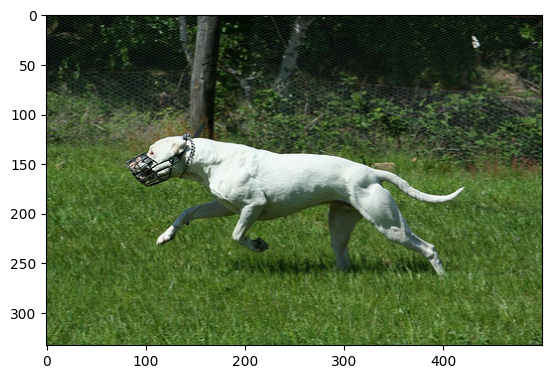

In [280]:
sample_img_path = os.path.join(images_path, val_df['image'].iloc[3])
img = Image.open(sample_img_path)
plt.imshow(img)

generate_caption(decoder_model, encoder_model,img, vocab, device=device)